# Kaggle

В этом домашнем задании вам нужно будет построить модель для данных соревнования [Titanic на Kaggle](https://www.kaggle.com/c/titanic/overview), сформировать файл с предсказаниями для тестовых данных и отправить его на проверку.

В практике из урока вашим заданием было разобрать одно из самых популярных ядер для соревнования Titanic и преобразовать его таким образом, чтобы остались только преобразование данных и графики.

Соответственно, сейчас ваше ядро должно выглядеть таким образом:

In [152]:
import pandas as pd
import re
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [166]:
# Load in the train and test datasets
train = pd.read_csv('titanic/train.csv')
test = pd.read_csv('titanic/test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


In [167]:
full_data = [train, test]

# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
# train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
# train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

    # # Mapping Fare
    # dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    # dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    # dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    # dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    # dataset['Fare'] = dataset['Fare'].astype(int)
    # 
    # # Mapping Age
    # dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    # dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 18), 'Age'] = 1
    # dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    # dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 26), 'Age'] = 3
    # dataset.loc[(dataset['Age'] > 26) & (dataset['Age'] <= 32), 'Age'] = 4
    # dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 5
    # dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 6
    # dataset.loc[ dataset['Age'] > 64, 'Age'] = 7
    


[     PassengerId  Survived  Pclass  \
 0              1         0       3   
 1              2         1       1   
 2              3         1       3   
 3              4         1       1   
 4              5         0       3   
 ..           ...       ...     ...   
 886          887         0       2   
 887          888         1       1   
 888          889         0       3   
 889          890         1       1   
 890          891         0       3   
 
                                                   Name  Sex  Age  SibSp  \
 0                              Braund, Mr. Owen Harris    1   22      1   
 1    Cumings, Mrs. John Bradley (Florence Briggs Th...    0   38      1   
 2                               Heikkinen, Miss. Laina    0   26      0   
 3         Futrelle, Mrs. Jacques Heath (Lily May Peel)    0   35      1   
 4                             Allen, Mr. William Henry    1   35      0   
 ..                                                 ...  ...  ...    ...  

In [168]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
for dataset in full_data:
    dataset[['Age', 'Fare', 'Name_length']] = sc.fit_transform(dataset[['Age', 'Fare','Name_length']])

full_data[0].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,-0.552144,1,0,A/5 21171,-0.502445,NaN,0,-0.427451,0,2,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,0.630098,1,0,PC 17599,0.786845,C85,1,2.590962,1,2,0,3
2,3,1,3,"Heikkinen, Miss. Laina",0,-0.256584,0,0,STON/O2. 3101282,-0.488854,NaN,0,-0.535252,0,1,1,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,0.408428,1,0,113803,0.420730,C123,0,1.836359,1,2,0,3
4,5,0,3,"Allen, Mr. William Henry",1,0.408428,0,0,373450,-0.486337,NaN,0,-0.319651,0,1,1,1


In [169]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
# train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

train

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,-0.552144,0,-0.502445,0,-0.427451,0,2,0,1
1,1,1,0,0.630098,0,0.786845,1,2.590962,1,2,0,3
2,1,3,0,-0.256584,0,-0.488854,0,-0.535252,0,1,1,2
3,1,1,0,0.408428,0,0.420730,0,1.836359,1,2,0,3
4,0,3,1,0.408428,0,-0.486337,0,-0.319651,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,-0.182694,0,-0.386671,0,-0.643052,0,1,1,5
887,1,1,0,-0.773815,0,-0.044381,0,0.111551,1,1,1,2
888,0,3,0,-0.478254,2,-0.176263,0,1.405157,0,4,0,2
889,1,1,1,-0.256584,0,-0.044381,1,-0.643052,1,1,1,1


In [170]:
# Feature selection
drop_elements = ['Name_length',]
train = train.drop(drop_elements, axis = 1)
# train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

train

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,-0.552144,0,-0.502445,0,0,2,0,1
1,1,1,0,0.630098,0,0.786845,1,1,2,0,3
2,1,3,0,-0.256584,0,-0.488854,0,0,1,1,2
3,1,1,0,0.408428,0,0.420730,0,1,2,0,3
4,0,3,1,0.408428,0,-0.486337,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,-0.182694,0,-0.386671,0,0,1,1,5
887,1,1,0,-0.773815,0,-0.044381,0,1,1,1,2
888,0,3,0,-0.478254,2,-0.176263,0,0,4,0,2
889,1,1,1,-0.256584,0,-0.044381,1,1,1,1,1


0    2
1    5
2    3
3    5
4    5
5    4
6    6
7    0
8    4
9    0
Name: Age, dtype: int32

<Axes: title={'center': 'Pearson Correlation of Features'}>

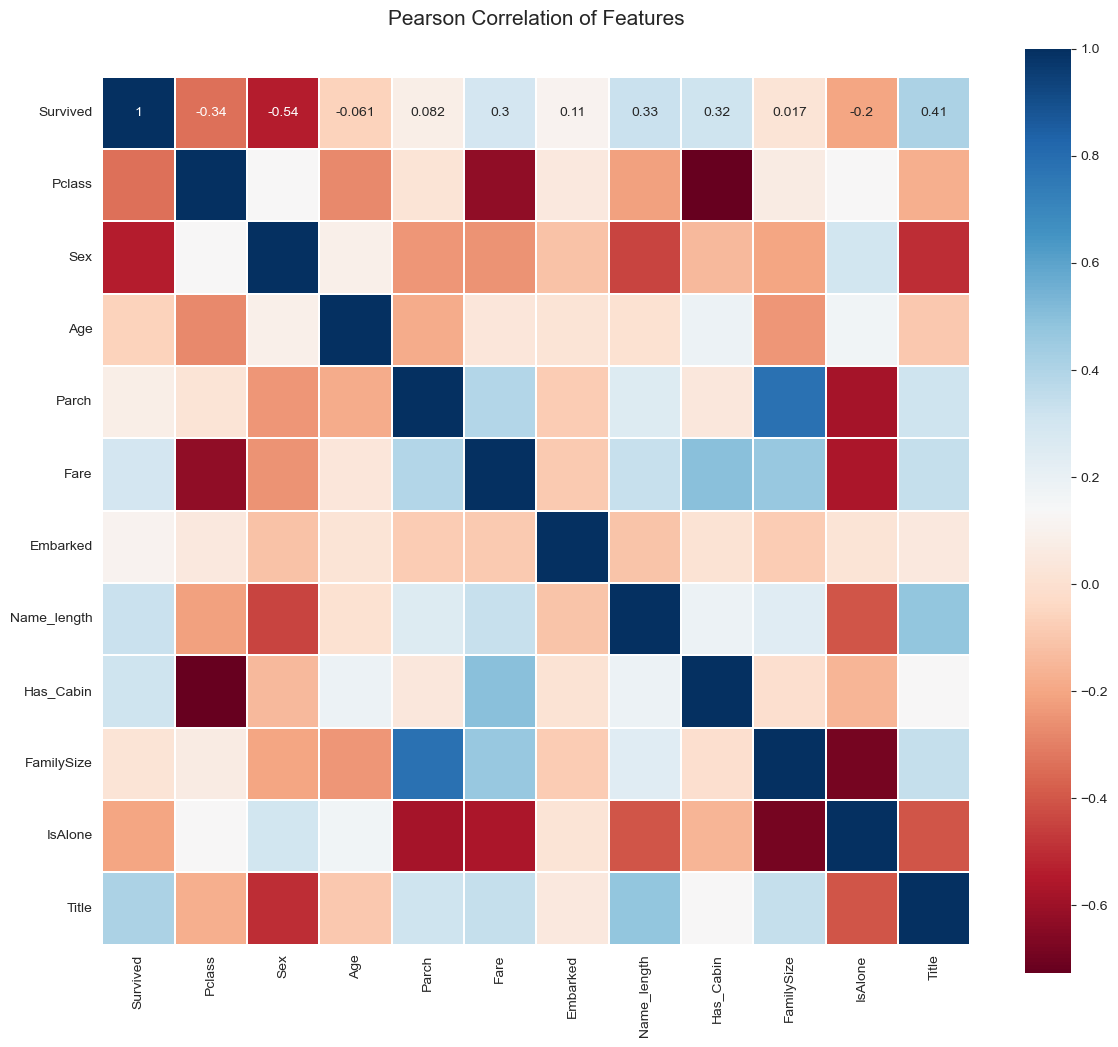

In [50]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0,
            square=True, cmap=colormap, linecolor='white', annot=True)

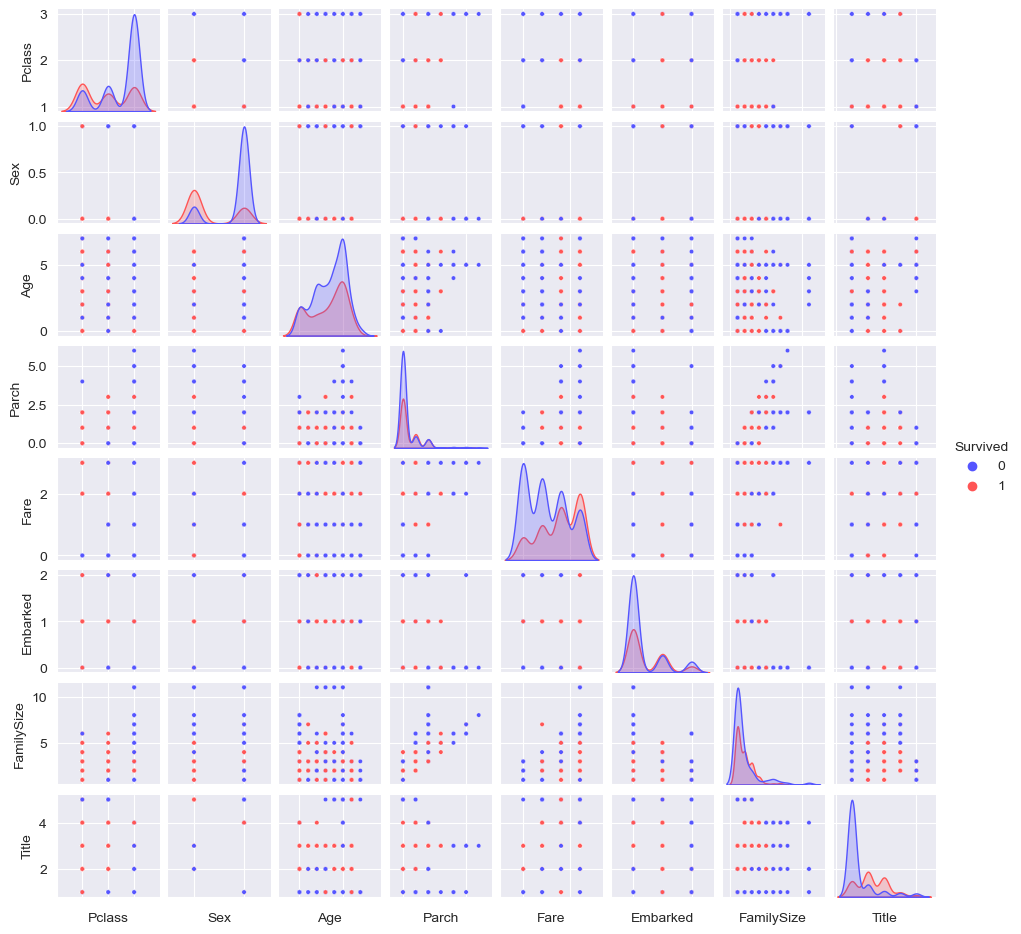

In [51]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare',
                        u'Embarked', u'FamilySize', u'Title']],
                 hue='Survived', palette = 'seismic', size=1.2, plot_kws=dict(s=10))
g.set(xticklabels=[])

Итак, у нас получились два датасета с новыми признаками. Теперь приступим к построению модели.

### Построение модели

### 1.

Воспользуйтесь вашим алгоритмом стекинга из предыдущего домашнего задания. В качестве базовых алгоритмов используйте RandomForestClassifier, SVC, GradientBoostingClassifier и LogisticRegression; в качестве мета-алгоритма - XGBoost.

Разделите данные train на тренировочную и валидационную выборки с random_state=17 и параметром разбиения test_size=.3 (в качестве целевой переменной возьмите столбец Survived, а в качестве признаков - все остальные столбцы).

Ниже приведены параметры для каждого из базовых алгоритмов, которые необходимо настроить на 5-кратной кросс-валидации с помощью GridSearchCV:

In [195]:
from sklearn.model_selection import (GridSearchCV,
                                     train_test_split,
                                     StratifiedKFold)

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import numpy as np

# параметры базовых алгоритмов
gbc_params = {'learning_rate': np.arange(0.1, 0.6, 0.1),
              'min_weight_fraction_leaf':np.arange(0.0,0.5,0.1),
              'max_depth': [1,2,3,4,5,6,7,8]
              },# GradientBoostingClassifier

rfc_params = {'n_estimators': range(10, 100, 10),  # RandomForestClassifier
              'min_samples_leaf': range(1, 5),
              'max_depth': [1,2,3,4,5,6,7,8],}

svc_params = {'kernel': ['linear', 'rbf'],  # SVC
              'C': np.arange(0.1, 1, 0.2)}

lr_params = {'C': np.arange(0.5, 1, 0.1), 'max_iter': range(10, 100, 10),}
skf = StratifiedKFold(n_splits=5, random_state=17., shuffle=True)


y = train.Survived
X = train.drop(columns='Survived')

x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=17)

lr = LogisticRegression()
svc = SVC()
rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()


g1 = GridSearchCV(lr,lr_params,cv=5).fit(x_train,y_train)
lr = lr.set_params(**g1.best_params_)
y_pred = lr.fit(x_train,y_train).predict(x_test)
print('liner',roc_auc_score(y_test,y_pred))

g2 = GridSearchCV(svc,svc_params,cv=5).fit(x_train,y_train)
svc = svc.set_params(**g2.best_params_)
y_pred = svc.fit(x_train,y_train).predict(x_test)
print('svc',roc_auc_score(y_test,y_pred))

g3 = GridSearchCV(rfc,rfc_params,cv=5).fit(x_train,y_train)
rfc = rfc.set_params(**g3.best_params_)
y_pred = rfc.fit(x_train,y_train).predict(x_test)
print('rfc',roc_auc_score(y_test,y_pred))

g4 = GridSearchCV(gbc,gbc_params,cv=5).fit(x_train,y_train)
gbc = gbc.set_params(**g4.best_params_)
y_pred = gbc.fit(x_train,y_train).predict(x_test)
print('gbc ',roc_auc_score(y_test,y_pred))


liner 0.789674334453347
svc 0.7969759627810804
rfc 0.7837296459033343
gbc  0.7854096665805118


In [199]:
from sklearn.ensemble import HistGradientBoostingClassifier

knn = HistGradientBoostingClassifier()

knn_params = {'l2_regularization': np.arange(0.0,0.5,0.1)}

g7 = GridSearchCV(knn,knn_params,cv=5).fit(x_train,y_train)
knn = knn.set_params(**g7.best_params_)
y_pred = knn.fit(x_train,y_train).predict(x_test)
print('knn ',roc_auc_score(y_test,y_pred))
g7.best_params_


knn  0.8012406306539157


{'l2_regularization': 0.30000000000000004}

In [200]:
from sklearn.ensemble import ExtraTreesClassifier

ex = ExtraTreesClassifier()
ex_params = {'n_estimators': range(10, 100, 10),
             'max_depth': [1,2,3,4,5,6,7,8],}
g8 = GridSearchCV(ex,ex_params,cv=5).fit(x_train,y_train)
ex = ex.set_params(**g8.best_params_)
y_pred = ex.fit(x_train,y_train).predict(x_test)
print('knn ',roc_auc_score(y_test,y_pred))
g8.best_params_

knn  0.7905789609718273


{'max_depth': 8, 'n_estimators': 10}

In [137]:
lr2=LogisticRegression()
g1 = GridSearchCV(lr2,lr_params,cv=5).fit(X,y)
lr2 = lr2.set_params(**g1.best_params_)

svc2 = SVC()
g2 = GridSearchCV(svc2,svc_params,cv=5).fit(X,y)
svc2 = svc2.set_params(**g2.best_params_)

rfc2=RandomForestClassifier()
g3 = GridSearchCV(rfc2,rfc_params,cv=5).fit(X,y)
rfc2 = rfc2.set_params(**g3.best_params_)

gbc2 = GradientBoostingClassifier()
g4 = GridSearchCV(gbc2,gbc_params,cv=5).fit(X,y)
gbc2 = gbc2.set_params(**g4.best_params_)


### 2.
1. Определите объект GridSearchCV для всех приведенных параметров каждого алгоритма (в гиперпараметрах алгоритма при его определении, если возможно, укажите random_state=17). Параметр cv устанавливайте равным skf.

2. Обучите каждый из объектов из 1-го пункта на получившейся при разбиении тренировочной выборке. Выведите лучшее сочетание параметров для каждого из алгоритмов.

3. Для каждого обученного алгоритма получите предсказания на валидационных данных и выведите метрику качества, которая соответствует метрике оценки соревнования.

In [146]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score


def stacking(models, meta_alg, data_train, targets_train, data_test, targets_test=None, random_state=None, test_size=None, cv=5):
    if test_size is None:
        
        meta_mtrx = np.empty((data_train.shape[0], len(models)))
        folds = StratifiedKFold(n_splits=cv)
        for n, model in enumerate(models):
            meta_mtrx[:,n] = cross_val_predict(model, data_train, targets_train, cv=folds)
            
              
        meta_model = meta_alg.fit(meta_mtrx, targets_train)
        meta_mtrx_test = np.empty((data_test.shape[0], len(models)))
        
        for n, model in enumerate(models):
            meta_mtrx_test[:, n] = model.fit(data_train, targets_train).predict(data_test)
    
        meta = meta_model.predict(meta_mtrx_test)
        if targets_test is not None:
            print(roc_auc_score(targets_test,meta))
            
        return meta

    elif test_size > 0 and test_size < 1:
        x_train, valid, y_train, valid_true = train_test_split(data_train,
                                                      targets_train,
                                                      test_size=test_size,
                                                      random_state=random_state or 0)
    
        meta_mtrx = np.empty((valid.shape[0], len(models)))
        for n, model in enumerate(models):
            model.fit(x_train, y_train)
            meta_mtrx[:,n] = model.predict(valid)
            
              
        meta_model = meta_alg.fit(meta_mtrx, valid_true)
        meta_mtrx_test = np.empty((data_test.shape[0], len(models)))
        
        for n, model in enumerate(models):
            meta_mtrx_test[:, n] = model.predict(data_test)
    
        meta = meta_model.predict(meta_mtrx_test)
        if targets_test is not None:
            print(roc_auc_score(targets_test,meta))
            
        return meta

    else:
        raise ValueError("test_size must be between 0 and 1")

### 3.
С помощью GridSearchCV и указанных ниже параметров настройте мета-алгоритм на мета-признаках (используйте 5-кратную валидацию и random_state=17 при определении алгоритма). Матрицу метапризнаков получите из предсказаний, полученных в предыдущем пункте на валидационных данных базовыми алгоритмами. Выведите лучшие параметры.

In [141]:
import xgboost

xgb_params = {'n_estimators': range(10, 100, 5),
              'eta': np.arange(0.5, 1., .5),
              'min_child_weight': range(1, 10, 1),
              'subsample': np.arange(0.1, 1., 0.3)}
xgb = xgboost.XGBClassifier()


In [175]:
g5 = GridSearchCV(xgb,xgb_params,cv=5).fit(x_train,y_train)
xgb = xgb.set_params(**g5.best_params_)
with open('best_params2.txt', 'w') as f:
    f.write(str(g5.best_params_))
y_pred = xgb.fit(x_train,y_train).predict(x_test)
print('xgb ',roc_auc_score(y_test,y_pred))

xgb  0.789674334453347


In [142]:
xgb2 = XGBClassifier()
g5 = GridSearchCV(xgb2,xgb_params,cv=5).fit(X,y)
xgb2 = xgb.set_params(**g5.best_params_)

### 4.
На основе алгоритма из предыдущего домашнего задания постройте стекинг (используйте 5-кратную кросс-валидацию) для всех моделей с наилучшими подобранными параметрами. В качестве тренировочных данных используйте весь датасет train.csv, а в качестве тестовых - весь датасет test.csv. Сделайте прогноз мета-алгоритма для test.csv.

In [203]:
models = [gbc,rfc,lr,svc,knn,ex]

prediction = stacking(models, xgb, X,y,test, random_state=17)
prediction

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

### 5.
С помощью нижеприведенной функции сформируйте файл посылки для соревнования и отправьте на Kaggle.

In [63]:
def write_to_submission_file(predictions, PassengerID, out_file='Submission.csv', columns=['PassengerID', 'Survived']):
    predicted_df = pd.DataFrame(np.array([PassengerId, predictions]).T, columns=columns)
    predicted_df.to_csv(out_file, index=False)

In [204]:
write_to_submission_file(prediction, PassengerID='PassengerID', out_file='Submission.csv')

### 6.
Каков результат score, полученного на соревновании?

Ваш ответ: